Keithley 2400 GUI - Software to apply constant voltage

Importing libraries + initializing global variables

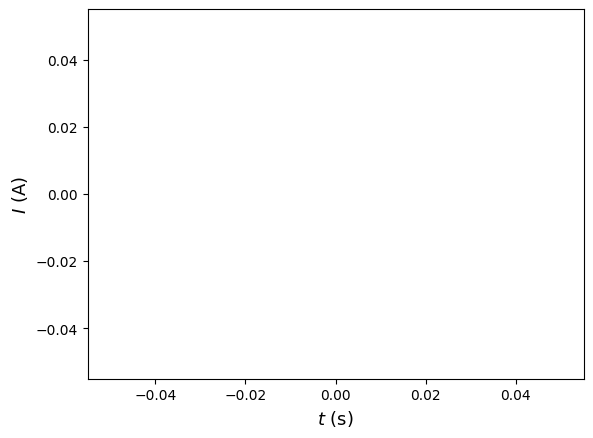

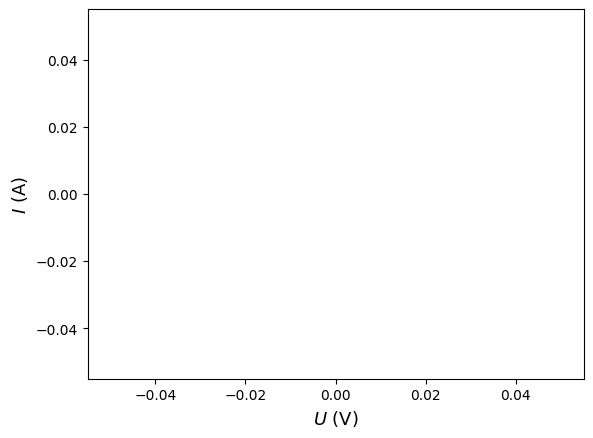

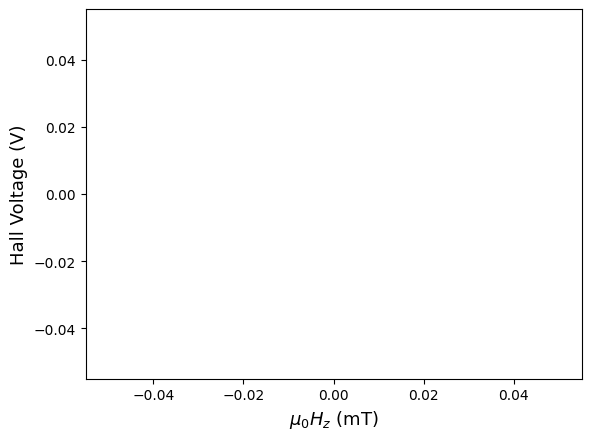

In [6]:
import tkinter as tk
from tkinter import font as tkFont
from tkinter import ttk, filedialog, messagebox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import time as tm
import datetime
import json
import os
import sys
import pyautogui
import pyperclip
import threading
import keyboard
import pygetwindow as gw

# import Keithley 2400; address 24
from pymeasure.instruments.keithley import Keithley2400
import pyvisa

# global variables
keithley = None
fig, ax = plt.subplots()
line, = ax.plot([], [], 'bo-')
ax.set_xlabel('$t$ (s)', fontsize=13)
ax.set_ylabel('$I$ (A)', fontsize=13)

fig_IV, ax_IV = plt.subplots()
line_IV, = ax_IV.plot([], [], 'bo-')
ax_IV.set_xlabel('$U$ (V)', fontsize=13)
ax_IV.set_ylabel('$I$ (A)', fontsize=13)

fig_hall, ax_hall = plt.subplots()
line_hall, = ax_hall.plot([], [], 'bo-')
ax_hall.set_xlabel('$\mu_{0}H_{z}$ (mT)', fontsize=13)
ax_hall.set_ylabel('Hall Voltage (V)', fontsize=13)

# measurement status
measurement_active = False
measurement_completed = False

# Kerr control - tracking the field
magnetic_fields = []
button_x = 0
button_y = 0
field_x = 0
field_y = 0
stop_tracking = False

# measurement number
measurement_number = 1
measurement_number_IV = 1
measurement_number_hall = 1

# remembering the plot
measurement_data = {}
measurement_data_IV = {}
measurement_data_hall = {}

# data storage
times_data, currents_data, voltages_data = [], [], []
times_data_IV, currents_data_IV, voltages_data_IV = [], [], []
times_data_hall, currents_data_hall, voltages_data_hall = [], [], []

# store the last used sample and file path
config_file = 'last_session.json'

# lock file
lockfile = "app.lock"

Trigger - start measurement

In [7]:
def load_last_session():
    if os.path.exists(config_file):
        with open(config_file, 'r') as file:
            config = json.load(file)

            # DC mode
            sample_name.set(config.get('sample_name', ''))
            file_path.set(config.get('file_path', ''))

            # IV mode
            sample_name_IV.set(config.get('sample_name', ''))
            file_path_IV.set(config.get('file_path', ''))

            # hall mode
            sample_name_hall.set(config.get('sample_name', ''))
            file_path_hall.set(config.get('file_path', ''))
            print(f"Loaded session: sample_name={sample_name.get()}, file_path={file_path.get()}")  # debugging
    else:
        print("No previous session found.")  # debugging

def save_last_session():
    # We'll save based on the current active tab
    current_tab = tab_control.select()
    if current_tab == tab_control.tabs()[0]:  # DC mode
        sample = sample_name.get()
        path = file_path.get()
        #mode = 'DC'
    elif current_tab == tab_control.tabs()[1]:  # IV curve mode
        sample = sample_name_IV.get()
        path = file_path_IV.get()
        #mode = 'IV'
    else:  # Hall mode
        sample = sample_name_hall.get()
        path = file_path_hall.get()
        #mode = 'Hall'

    config = {
        'sample_name': sample,
        'file_path': path
    }
    print(f"Saving session: {config}")  # debugging
    with open(config_file, 'w') as file:
        json.dump(config, file)

# prevent running multiple times
def is_already_running():
    return os.path.exists(lockfile)

def create_lockfile():
    with open(lockfile, "w") as file:
        file.write("lock")

def remove_lockfile():
    if os.path.exists(lockfile):
        os.remove(lockfile)

def show_error_and_exit(message):
    messagebox.showerror("Error", message)
    sys.exit()

if is_already_running():
    root = tk.Tk()
    root.withdraw()
    show_error_and_exit("Software already running.")
else:
    create_lockfile()

# pop-up window on closing
def on_closing():
    popup = tk.Toplevel(root)
    popup.title("Reminder")

    # calculate center position relative to the size of the software
    root_x = root.winfo_x()
    root_y = root.winfo_y()
    root_width = root.winfo_width()
    root_height = root.winfo_height()

    popup_width = 300
    popup_height = 90
    pos_x = root_x + (root_width // 2) - (popup_width // 2)
    pos_y = root_y + (root_height // 2) - (popup_height // 2)
    
    popup.geometry(f"{popup_width}x{popup_height}+{pos_x}+{pos_y}")

    label = ttk.Label(popup, text="Please remember to turn off the Keithley.", wraplength=250)
    label.pack(pady=10)

    ok_button = ttk.Button(popup, text="OK", command=lambda: [save_last_session(), root.destroy()])
    ok_button.pack(pady=5)

    popup.transient(root)
    popup.grab_set()
    root.wait_window(popup)

    remove_lockfile()

def get_current_value(x, y):
    calibration_factor = 137.91 # calibration for the field
    pyautogui.moveTo(x, y)
    pyautogui.doubleClick()
    pyautogui.hotkey('ctrl', 'c')
    tm.sleep(0.1)
    pyautogui.moveTo(x, y)
    raw_value = float(pyperclip.paste())
    return raw_value * calibration_factor

def initialize_button_position(left, top, width, height):
    tm.sleep(0.1)
    x_factor = 890/953 #button to window ratio
    y_factor = 58/572
    x = left + x_factor * width
    y = top + y_factor * height
    return x, y

def initialize_value_position(left, top, width, height):
    tm.sleep(0.1)
    x_factor = 880/953 #value field to window ratio
    y_factor = 93/572
    x = left + x_factor * width
    y = top + y_factor * height
    return x, y

def listen_for_enter():
    global stop_tracking
    keyboard.wait('enter')
    stop_tracking = True
    status_label_hall.config(text="Measurement stopped by user.")

def should_stop_tracking_Hall(current_value, last_value, positive_reached):
    if current_value > 0:
        positive_reached = True

    if (abs(current_value) < 0.001 and
        positive_reached and
        last_value < 0):
        return True, positive_reached
    
    return False, positive_reached



In [8]:
# saving the data, updating plot

def save_file_with_confirmation(filepath, content, mode='DC'):
    if os.path.exists(filepath):
        response = messagebox.askquestion("File exists", "File already exists. Do you want to overwrite?", icon='warning')
        if response == 'yes':
            # overwrite the file
            with open(filepath, 'w', encoding="utf-8") as f:
                f.write(content)
            if mode == 'DC':
                status_label.config(text="File overwritten successfully.", justify='center')
            elif mode == 'IV':
                status_label_IV.config(text="File overwritten successfully.", justify='center')
            elif mode == 'Hall':
                status_label_hall.config(text="File overwritten successfully.", justify='center')
        elif response == 'no':
            # keep both files, generate new filename
            base, ext = os.path.splitext(filepath)
            i = 1
            new_filepath = f"{base}_{i}{ext}"
            while os.path.exists(new_filepath):
                i += 1
                new_filepath = f"{base}_{i}{ext}"
            with open(new_filepath, 'w', encoding="utf-8") as f:
                f.write(content)
            if mode == 'DC':
                status_label.config(text="File saved successfully.", justify='center')
            elif mode == 'IV':
                status_label_IV.config(text="File saved successfully.", justify='center')
            elif mode == 'Hall':
                status_label_hall.config(text="File saved successfully.", justify='center')
    else:
        # file does not exist, save normally
        with open(filepath, 'w', encoding="utf-8") as f:
            f.write(content)
        if mode == 'DC':
            status_label.config(text="File saved successfully.", justify='center')
        elif mode == 'IV':
            status_label_IV.config(text="File saved successfully.", justify='center')
        elif mode == 'Hall':
            status_label_hall.config(text="File saved successfully.", justify='center')

'''
def save_data():
    if sample_name.get() and file_path.get():
        try:
            sample = sample_name.get()
            data_output_filename = f"{file_path.get()}/{sample}.txt"
            content = "I (A)\tt (s)\tU (V)\tR (Ohm)\n"
            
            for t, I, V in zip(times_data, currents_data, voltages_data):
                try:
                    R = (V/I) if I !=0 else float('inf')
                    formatted_resistance = f"{R:.4g}"
                except:
                    formatted_resistance = "inf"

                formatted_current = f"{I:.4g}"
                formatted_time = f"{t:.4f}"
                formatted_voltage = f"{V:.4f}"
                content += f"{formatted_current}\t{formatted_time}\t{formatted_voltage}\t{formatted_resistance}\n"
                
            save_file_with_confirmation(data_output_filename, content, mode='DC')
        except Exception as e:
            status_label.config(text=f"Error saving data: {str(e)}")
    else:
        status_label.config(text="Please enter the sample name and select the file path.")


def save_data_IV():
    if sample_name_IV.get() and file_path_IV.get():
        try:
            sample = sample_name_IV.get()
            data_output_filename = f"{file_path_IV.get()}/{sample}_IV.txt"
            content = "I (A)\tt (s)\tU (V)\tR (Ohm)\n"

            for t, I, V in zip(times_data_IV, currents_data_IV, voltages_data_IV):

                try:
                    R = (V/I) if I !=0 else float('inf')
                    formatted_resistance = f"{R:.4g}"
                except:
                    formatted_resistance = "inf"

                formatted_current = f"{I:.4g}"
                formatted_time = f"{t:.4f}"
                formatted_voltage = f"{V:.4f}"
                content += f"{formatted_current}\t{formatted_time}\t{formatted_voltage}\t{formatted_resistance}\n"

            save_file_with_confirmation(data_output_filename, content, mode='IV')
        except Exception as e:
            status_label_IV.config(text=f"Error saving data: {str(e)}")
    else:
        status_label_IV.config(text="Please enter the sample name and select the file path.")


def save_hall_data():
    if sample_name_hall.get() and file_path_hall.get():
        try:
            sample = sample_name_hall.get()
            data_output_filename = f"{file_path_hall.get()}/{sample}_hall.txt"
            
            # Get the current value that was used
            current_value = float(current_hall.get())
            if current_hall_unit.get() == 'mA':
                current_value *= 1e-3
            elif current_hall_unit.get() == '\u03BCA':  # micro ampere
                current_value *= 1e-6
                
            # Create header and data content
            content = "Magnetic Field (mT)\tHall Voltage (V)\tI (A)\tR (Ohm)\n"
            
            for field, voltage in zip(magnetic_fields, voltages_data_hall):
                try:
                    R = (voltage/current_value) if current_value !=0 else float('inf')
                    formatted_resistance = f"{R:.4g}"
                except:
                    formatted_resistance = "inf"

                content += f"{field}\t{voltage}\t{current_value}\t{formatted_resistance}\n"
                
            save_file_with_confirmation(data_output_filename, content, mode='Hall')
            
        except Exception as e:
            status_label_hall.config(text=f"Error saving data: {str(e)}.")
    else:
        status_label_hall.config(text="Please enter the sample name and select the file path.")

'''

def remove_marked():
    selected_items = results_table.selection()  # Get the selected items

    # Check if any items are selected
    if not selected_items:
        print("No items selected to remove.")
    else:
        for item in selected_items:
            # Get the measurement number (if needed for logging)
            measurement_num = int(results_table.item(item)['values'][0])
            
            # Remove the item from the results_table
            results_table.delete(item)

        
        #Renumerate rows
        for index, item in enumerate(results_table.get_children()):
            # Get the current values of the row
            current_values = results_table.item(item)['values']
            
            new_number = index + 1 
            current_values[0] = new_number  # Update the first field (Number)
            
            # Update the row with the new values
            results_table.item(item, values=current_values)

def remove_marked_IV():
    selected_items = history_table_IV.selection()  # Get the selected items

    # Check if any items are selected
    if not selected_items:
        print("No items selected to remove.")
    else:
        for item in selected_items:
            # Get the measurement number (if needed for logging)
            measurement_num = int(history_table_IV.item(item)['values'][0])
            
            # Remove the item from the results_table
            history_table_IV.delete(item)

        
        #Renumerate rows
        for index, item in enumerate(history_table_IV.get_children()):
            # Get the current values of the row
            current_values = history_table_hall.item(item)['values']
            
            new_number = index + 1 
            current_values[0] = new_number  # Update the first field (Number)
            
            # Update the row with the new values
            history_table_IV.item(item, values=current_values)


def remove_marked_hall():
    selected_items = history_table_hall.selection()  # Get the selected items

    # Check if any items are selected
    if not selected_items:
        print("No items selected to remove.")
    else:
        for item in selected_items:
            # Get the measurement number (if needed for logging)
            measurement_num = int(history_table_hall.item(item)['values'][0])
            
            # Remove the item from the results_table
            history_table_hall.delete(item)

        
        #Renumerate rows
        for index, item in enumerate(history_table_hall.get_children()):
            # Get the current values of the row
            current_values = history_table_hall.item(item)['values']
            
            new_number = index + 1 
            current_values[0] = new_number  # Update the first field (Number)
            
            # Update the row with the new values
            history_table_hall.item(item, values=current_values)

def save_selected_dc():
    selected_items = results_table.selection()
    if not selected_items:
        messagebox.showwarning("No Selection", "Please select a measurement from the table first.")
        return
        
    selected_item = selected_items[0]  # Get the first selected item
    measurement_num = int(results_table.item(selected_item)['values'][0])  # Get measurement number
    
    if measurement_num in measurement_data:
        # Get file path
        file_path_str = file_path.get()
        if not file_path_str:
            file_path_str = filedialog.askdirectory()
            if not file_path_str:
                return
            file_path.set(file_path_str)
            
        # Create filename with measurement details
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        sample_name_str = sample_name.get() or "Unknown"
        filename = f"{sample_name_str}_DC_measurement_{measurement_num}.txt"
        full_path = os.path.join(file_path_str, filename)
        
        # Save the data
        data = measurement_data[measurement_num]
        with open(full_path, 'w') as f:
            f.write(f"Sample: {data['sample']}\n")
            f.write(f"Time: {data['time']}\n")
            f.write(f"Duration: {data['duration']:.2f} s\n")
            f.write("\nTime (s)\tVoltage (V)\tCurrent (A)\n")
            for t, v, i in zip(data['times'], data['voltages'], data['currents']):
                f.write(f"{t:.3f}\t{v:.6e}\t{i:.6e}\n")
                
        messagebox.showinfo("Success", f"Data saved to:\n{full_path}")
    else:
        messagebox.showerror("Error", "Measurement data not found.")

def save_selected_IV():
    selected_items = history_table_IV.selection()
    if not selected_items:
        messagebox.showwarning("No Selection", "Please select a measurement from the table first.")
        return
        
    selected_item = selected_items[0]
    measurement_num = int(history_table_IV.item(selected_item)['values'][0])
    
    if measurement_num in measurement_data_IV:
        file_path_str = file_path_IV.get()
        if not file_path_str:
            file_path_str = filedialog.askdirectory()
            if not file_path_str:
                return
            file_path_IV.set(file_path_str)
            
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        sample_name_str = sample_name_IV.get() or "Unknown"
        filename = f"{sample_name_str}_IV_measurement_{measurement_num}.txt"
        full_path = os.path.join(file_path_str, filename)
        
        data = measurement_data_IV[measurement_num]
        with open(full_path, 'w') as f:
            f.write(f"Sample: {data['sample']}\n")
            f.write(f"Time: {data['time']}\n")
            f.write(f"Duration: {data['duration']:.2f} s\n")
            f.write("\nVoltage (V)\tCurrent (A)\n")
            for v, i in zip(data['voltages'], data['currents']):
                f.write(f"{v:.6e}\t{i:.6e}\n")
                
        messagebox.showinfo("Success", f"Data saved to:\n{full_path}")
    else:
        messagebox.showerror("Error", "Measurement data not found.")

def save_selected_hall():
    selected_items = history_table_hall.selection()
    if not selected_items:
        messagebox.showwarning("No Selection", "Please select a measurement from the table first.")
        return
        
    selected_item = selected_items[0]
    measurement_num = int(history_table_hall.item(selected_item)['values'][0])
    
    if measurement_num in measurement_data_hall:
        file_path_str = file_path_hall.get()
        if not file_path_str:
            file_path_str = filedialog.askdirectory()
            if not file_path_str:
                return
            file_path_hall.set(file_path_str)
            
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        sample_name_str = sample_name_hall.get() or "Unknown"
        filename = f"{sample_name_str}_Hall_measurement_{measurement_num}.txt"
        full_path = os.path.join(file_path_str, filename)
        
        data = measurement_data_hall[measurement_num]
        with open(full_path, 'w') as f:
            f.write(f"Sample: {data['sample']}\n")
            f.write(f"Time: {data['time']}\n")
            f.write(f"Duration: {data['duration']:.2f} s\n")
            f.write("\nMagnetic Field (mT)\tHall Voltage (V)\n")
            for b, v in zip(data['magnetic_fields'], data['voltages']):
                f.write(f"{b:.6e}\t{v:.6e}\n")
                
        messagebox.showinfo("Success", f"Data saved to:\n{full_path}")
    else:
        messagebox.showerror("Error", "Measurement data not found.")



def save_plot_only():
    if sample_name.get() and file_path.get():
        try:
            sample = sample_name.get()
            plot_output_filename = f"{file_path.get()}/{sample}_plot.png"
            if os.path.exists(plot_output_filename):
                response = messagebox.askquestion("File exists", "Plot already exists. Do you want to overwrite?", icon='warning')
                if response == 'yes':
                    fig.savefig(plot_output_filename)
                    status_label.config(text="Plot overwritten successfully.")
                elif response == 'no':
                    base, ext = os.path.splitext(plot_output_filename)
                    i = 1
                    new_plot_filename = f"{base}_{i}{ext}"
                    while os.path.exists(new_plot_filename):
                        i += 1
                        new_plot_filename = f"{base}_{i}{ext}"
                    fig.savefig(new_plot_filename)
                    status_label.config(text="Plot saved successfully.")
            else:
                fig.savefig(plot_output_filename)
                status_label.config(text="Plot saved successfully.")
        except Exception as e:
            status_label.config(text=f"Error saving plot: {str(e)}")
    else:
        status_label.config(text="Please enter the sample name and select the file path.")


def save_plot_only_IV():
    if sample_name_IV.get() and file_path_IV.get():
        try:
            sample = sample_name_IV.get()
            plot_output_filename = f"{file_path_IV.get()}/{sample}_IV_plot.png"
            if os.path.exists(plot_output_filename):
                response = messagebox.askquestion("File exists", "Plot already exists. Do you want to overwrite?", icon='warning')
                if response == 'yes':
                    fig_IV.savefig(plot_output_filename)
                    status_label_IV.config(text="Plot overwritten successfully.")
                elif response == 'no':
                    base, ext = os.path.splitext(plot_output_filename)
                    i = 1
                    new_plot_filename = f"{base}_{i}{ext}"
                    while os.path.exists(new_plot_filename):
                        i += 1
                        new_plot_filename = f"{base}_{i}{ext}"
                    fig_IV.savefig(new_plot_filename)
                    status_label_IV.config(text="Plot saved successfully.")
            else:
                fig_IV.savefig(plot_output_filename)
                status_label_IV.config(text="Plot saved successfully.")
        except Exception as e:
            status_label_IV.config(text=f"Error saving plot: {str(e)}")
    else:
        status_label_IV.config(text="Please enter the sample name and select the file path.")


def save_hall_plot():
    if sample_name_hall.get() and file_path_hall.get():
        try:
            sample = sample_name_hall.get()
            plot_output_filename = f"{file_path_hall.get()}/{sample}_hall_plot.png"
            
            # Make sure the axes are properly formatted before saving
            ax_hall.set_xlabel('$\mu_{0}H_{z}$ (mT)', fontsize=13)
            ax_hall.set_ylabel('Hall Voltage (V)', fontsize=13)
            ax_hall.grid(True)
            
            if os.path.exists(plot_output_filename):
                response = messagebox.askquestion("File exists", 
                    "Plot already exists. Do you want to overwrite?", icon='warning')
                if response == 'yes':
                    fig_hall.savefig(plot_output_filename)
                    status_label_hall.config(text="Plot overwritten successfully.")
                elif response == 'no':
                    base, ext = os.path.splitext(plot_output_filename)
                    i = 1
                    new_plot_filename = f"{base}_{i}{ext}"
                    while os.path.exists(new_plot_filename):
                        i += 1
                        new_plot_filename = f"{base}_{i}{ext}"
                    fig_hall.savefig(new_plot_filename)
                    status_label_hall.config(text="Plot saved successfully.")
            else:
                fig_hall.savefig(plot_output_filename)
                status_label_hall.config(text="Plot saved successfully.")
                
        except Exception as e:
            status_label_hall.config(text=f"Error saving plot: {str(e)}")
    else:
        status_label_hall.config(text="Please enter the sample name and select the file path.")


def select_file_path():
    selected_path = filedialog.askdirectory()
    if selected_path:
        # Update all file path variables
        file_path.set(selected_path)
        file_path_IV.set(selected_path)
        file_path_hall.set(selected_path)


def copy_data_to_clipboard():
    if len(times_data) > 0:
        # get the latest measurement results
        date_time = datetime.datetime.now().strftime("%d/%m/%y %H:%M")
        measurement_time = measurement_time_var.get()
        average_current = average_current_var.get()
        max_current = max_current_var.get()
        min_current = min_current_var.get()

        # format the data as a single row
        data_line = f"{date_time}\t{measurement_time}\t{average_current}\t{max_current}\t{min_current}\n"

        # copy the data to the clipboard
        root.clipboard_clear()
        root.clipboard_append(data_line)
        root.update()  # make sure the clipboard is updated
        status_label.config(text="Data copied to clipboard.")
    else:
        status_label.config(text="No data available to copy.")

   
def add_to_table(sample, set_voltage, average_current, duration):
    measurement_number = len(results_table.get_children()) + 1

    formatted_average_current = f"{average_current:.4g}"
    formatted_time = f"{duration:.5f}"

    try:
        average_resistance = (set_voltage/average_current) if average_current !=0 else float('inf')
        formatted_resistance = f"{average_resistance:.4g}"
    except:
        formatted_resistance = "inf"
    
    results_table.insert('', 'end', values=(measurement_number, sample, set_voltage, formatted_average_current, formatted_resistance, formatted_time))
    print("measurement_added")
    measurement_number += 1

def save_table_only():
    # Logic to save the table content to a .txt file
    if sample_name.get() and file_path.get():
        filepath = os.path.join(file_path.get(), f"{sample_name.get()}_table.txt")
        content = "Number\tSample\tU (V)\tI (A)\tR (Ω)\tt (s)\n"
        for row in results_table.get_children():
            values = results_table.item(row)['values']
            content += "\t".join(map(str, values)) + "\n"
        save_file_with_confirmation(filepath, content, mode='DC')
    else:
        status_label.config(text="Please enter the sample name and select the file path.")

# IV curve functions
def save_table_only_IV():
    if sample_name_IV.get() and file_path_IV.get():
        filepath = os.path.join(file_path_IV.get(), f"{sample_name_IV.get()}_IV_table.txt")
        content = "#\tSample\tU (V)\tI (A)\tR (Ω)\tt (s)\n"
        
        for row in history_table_IV.get_children():
            values = history_table_IV.item(row)['values']
            content += "\t".join(map(str, values)) + "\n"
            
        save_file_with_confirmation(filepath, content, mode='IV')
    else:
        status_label_IV.config(text="Please enter the sample name and select the file path.")

def save_table_only_hall():
    if sample_name_hall.get() and file_path_hall.get():
        filepath = os.path.join(file_path_hall.get(), f"{sample_name_hall.get()}_hall_table.txt")
        content = "#\tSample\tU (V)\tI (A)\tR (Ω)\tt (s)\n"
        
        for row in history_table_hall.get_children():
            values = history_table_hall.item(row)['values']
            content += "\t".join(map(str, values)) + "\n"
            
        save_file_with_confirmation(filepath, content, mode='Hall')
    else:
        status_label_hall.config(text="Please enter the sample name and select the file path.")

def copy_selected_entries_to_clipboard_IV():
    selected_items = history_table_IV.selection()
    
    # If nothing is selected, get the last entry
    if not selected_items:
        all_items = history_table_IV.get_children()
        if not all_items:  # If table is empty
            status_label_IV.config(text="No data available to copy.")
            return
        selected_items = [all_items[-1]]  # Get last item
    
    # Format header
    data_lines = ["#\tSample\tU (V)\tI (A)\tR (Ω)\tt (s)"]
    
    # Add each selected row
    for item in selected_items:
        values = history_table_IV.item(item)['values']
        data_line = "\t".join(map(str, values))
        data_lines.append(data_line)
    
    # Join all lines with newlines
    clipboard_text = "\n".join(data_lines)
    
    # Copy to clipboard
    root.clipboard_clear()
    root.clipboard_append(clipboard_text)
    root.update()
    
    status_label_IV.config(text="Data copied to clipboard.")

# Hall mode functions


def copy_selected_entries_to_clipboard_hall():
    selected_items = history_table_hall.selection()
    
    # If nothing is selected, get the last entry
    if not selected_items:
        all_items = history_table_hall.get_children()
        if not all_items:  # If table is empty
            status_label_hall.config(text="No data available to copy.")
            return
        selected_items = [all_items[-1]]  # Get last item
    
    # Format header
    data_lines = ["#\tSample\tU (V)\tI (A)\tR (Ω)\tt (s)"]
    
    # Add each selected row
    for item in selected_items:
        values = history_table_hall.item(item)['values']
        data_line = "\t".join(map(str, values))
        data_lines.append(data_line)
    
    # Join all lines with newlines
    clipboard_text = "\n".join(data_lines)
    
    # Copy to clipboard
    root.clipboard_clear()
    root.clipboard_append(clipboard_text)
    root.update()
    
    status_label_hall.config(text="Data copied to clipboard.")


def copy_selected_entries_to_clipboard():
    # Get all selected items
    selected_items = results_table.selection()
    
    # If nothing is selected, get the last entry
    if not selected_items:
        all_items = results_table.get_children()
        if not all_items:  # If table is empty
            status_label.config(text="No data available to copy.")
            return
        selected_items = [all_items[-1]]  # Get last item
    
    # Format header
    data_lines = ["Number\tSample\tU (V)\tI average (A)\tR (Ω)\tt (s)"]
    
    # Add each selected row
    for item in selected_items:
        values = results_table.item(item)['values']
        data_line = "\t".join(map(str, values))
        data_lines.append(data_line)
    
    # Join all lines with newlines
    clipboard_text = "\n".join(data_lines)
    
    # Copy to clipboard
    root.clipboard_clear()
    root.clipboard_append(clipboard_text)
    root.update()
    
    status_label.config(text="Data copied to clipboard.")


def clear_table():
    global measurement_number
    for item in results_table.get_children():
        results_table.delete(item)
    measurement_number = 1
    status_label.config(text="Table cleared.")


def clear_table_IV():
    global measurement_number_IV
    for item in history_table_IV.get_children():
        history_table_IV.delete(item)
    measurement_number_IV = 1
    measurement_data_IV.clear() 
    status_label_IV.config(text="Table cleared.")


def clear_table_hall():
    global measurement_number_hall
    for item in history_table_hall.get_children():
        history_table_hall.delete(item)
    measurement_number_hall = 1
    measurement_data_hall.clear() 
    status_label_hall.config(text="Table cleared.")


def show_selected_measurement_dc():
    selected_items = results_table.selection()
    if not selected_items:
        return
    
    # Clear current plot
    ax.clear()
    
    # Colors for multiple plots
    colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
    
    # Plot each selected measurement
    for i, item in enumerate(selected_items):
        measurement_num = int(results_table.item(item)['values'][0])
        print(f"measurement nb: {measurement_num}")
        
        if measurement_num in measurement_data:
            data = measurement_data[measurement_num]
            times = data['times']
            currents = data['currents']
            
            # Plot with different color and add to legend
            ax.plot(times, currents, f'{colors[i%len(colors)]}-o', 
                   label=f'Measurement #{measurement_num}')
    
    # Set labels and title
    ax.set_xlabel('$t$ (s)', fontsize=13)
    ax.set_ylabel('$I$ (A)', fontsize=13)
    ax.yaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.grid(True)
    ax.legend()
    
    # Redraw
    fig.canvas.draw()
    fig.canvas.flush_events()


def show_selected_measurement_hall():
    selected_items = history_table_hall.selection()
    if not selected_items:
        return
    
    # Clear current plot
    ax_hall.clear()
    
    # Colors for multiple plots
    colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
    
    # Plot each selected measurement
    for i, item in enumerate(selected_items):
        measurement_num = history_table_hall.item(item)['values'][0]
        
        if measurement_num in measurement_data_hall:
            data = measurement_data_hall[measurement_num]
            voltages = data['voltages']
            magnetic_fields = data['magnetic_fields']
            #currents = data['currents']
            
            # Plot with different color and add to legend
            ax_hall.plot(magnetic_fields, voltages, f'{colors[i%len(colors)]}-o', 
                      label=f'Measurement #{measurement_num}')
    
    # Set labels and title
    ax_hall.set_xlabel('$\mu_{0}H_{z}$ (mT)', fontsize=13)
    ax_hall.set_ylabel('Hall Voltage (V)', fontsize=13)
    ax_hall.yaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
    ax_hall.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax_hall.grid(True)
    ax_hall.legend()
    
    # Redraw
    fig_hall.canvas.draw()
    fig_hall.canvas.flush_events()


def show_selected_measurement_IV():
    selected_items = history_table_IV.selection()
    if not selected_items:
        return
    
    # Clear current plot
    ax_IV.clear()
    
    # Colors for multiple plots
    colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
    
    # Plot each selected measurement
    for i, item in enumerate(selected_items):
        measurement_num = history_table_IV.item(item)['values'][0]
        
        if measurement_num in measurement_data_IV:
            data = measurement_data_IV[measurement_num]
            voltages = data['voltages']
            currents = data['currents']
            
            # Plot with different color and add to legend
            ax_IV.plot(voltages, currents, f'{colors[i%len(colors)]}-o', 
                      label=f'Measurement #{measurement_num}')
    
    # Set labels and title
    ax_IV.set_xlabel('$U$ (V)', fontsize=13)
    ax_IV.set_ylabel('$I$ (A)', fontsize=13)
    ax_IV.yaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
    ax_IV.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax_IV.grid(True)
    ax_IV.legend()
    
    # Redraw
    fig_IV.canvas.draw()
    fig_IV.canvas.flush_events()

In [9]:
def toggle_delay_IV():
    if delay_IV.get():  # If checked
        delay_entry_IV.config(state='normal')
        unit_selector_IV_delay.config(state='normal')
    else:  # If unchecked
        delay_entry_IV.config(state='disabled')
        unit_selector_IV_delay.config(state='disabled')

        
def toggle_pulse_mode():
    if pulse_mode_var.get():  # If checked
        voltage_entry.config(state='disabled')
        duration_entry.config(state='disabled')
        compliance_current_entry.config(state='disabled')
    else:  # If unchecked
        voltage_entry.config(state='normal')
        duration_entry.config(state='normal')
        compliance_current_entry.config(state='normal')


def switch_measurement_mode(mode='voltage'):
    try:
        rm = pyvisa.ResourceManager()
        keithley_pyvisa = rm.open_resource('GPIB::24::INSTR')

        if mode.lower() == 'voltage':
            keithley_pyvisa.write(':SENS:FUNC "VOLT"')
            keithley_pyvisa.write(':SENS:VOLT:RANG:AUTO ON')
        elif mode.lower() == 'current':
            keithley_pyvisa.write(':SENS:FUNC "CURR"')
            keithley_pyvisa.write(':SENS:CURR:RANG:AUTO ON')

        #keithley_pyvisa.close()
        #rm.close()

    except Exception as e:
        status_label.config(text=f"Error switching measurement mode: {str(e)}.")

def set_sense_mode(mode='4-wire sensing'):
    global keithley
    try:
        #rm = pyvisa.ResourceManager()
        #keithley_pyvisa = rm.open_resource('GPIB::24::INSTR')

        if mode.lower() == '4-wire sensing':
            #keithley_pyvisa.write(':SENSE:VOLT:MODE 4WIRE')
            keithley.wires = 4
            print("4-wire sensing mode set.")
        elif mode.lower() == '2-wire sensing':
            #keithley_pyvisa.write(':SENSE:VOLT:MODE 2WIRE')
            keithley.wires = 2
            print("2-wire sensing mode set.")

    except Exception as e:
        status_label.config(text=f"Error setting sense mode: {str(e)}.")


def start_measurement():
    global keithley, fig, ax, line, measurement_active, measurement_completed, times_data, currents_data, voltages_data, sample
    
    try:
        # start button disabled
        start_button.config(state='disabled')
        
        # get values
        set_voltage = float(voltage.get())
        duration = float(duration_var.get())
        compliance_current_value = float(compliance_current.get())

        # get units
        voltage_unit_value = voltage_unit.get()
        time_unit_value = time_unit.get()
        compliance_current_unit_value = compliance_current_unit.get()

        # convert units (if necessary)
        if voltage_unit_value == 'mV':
            set_voltage *= 1e-3
        elif voltage_unit_value == '\u03BCV':
            set_voltage *= 1e-6

        if time_unit_value == 'ms':
            duration *= 1e-3

        if compliance_current_unit_value == 'mA':
            compliance_current_value *= 1e-3
        elif compliance_current_unit_value == '\u03BCA':
            compliance_current_value *= 1e-6

        # limits
        #if not (5e-6 <= set_voltage <=20):
        #    raise ValueError("Voltage must be between 5 µV and 20 V.")
        #if not (1e-6 <= compliance_current_value <=1):
        #    raise ValueError("Compliance current must be between 1 µA and 1 V.")

        # configure Keithley
        keithley = Keithley2400("GPIB::24::INSTR")
        keithley.voltage_nplc = 0.01  # fast measurement
        keithley.current_nplc = 0.01  # fast measurement
        keithley.source_mode = 'voltage'
        switch_measurement_mode('current')	
        keithley.compliance_current = compliance_current_value  # user-defined
        keithley.source_voltage = set_voltage
        #keithley.measure_current()  # user-defined

        # prepare live-plot
        ax.clear()
        line, = ax.plot([], [], color='blue', marker='o')
        
        # update plot title dynamically
        sample = sample_name.get()
        if sample:
            ax.set_title(f"DC mode measurement for {sample} ({datetime.datetime.now().strftime('%d/%m/%y')})", pad=10)
        else:
            ax.set_title(f"DC mode measurement for ({datetime.datetime.now().strftime('%d/%m/%y')})", pad=10)
            
        # set x-axis and y-axis titles
        ax.set_xlabel('$t$ (s)', fontsize=13)
        ax.set_ylabel('$I$ (A)', fontsize=13)
        ax.yaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax.grid(True)

        measurement_active = True
        measurement_completed = False
        status_label.config(text="Running...")
        stop_button.config(state='normal')  # Ensure the stop button is enabled

        

        # schedule the apply_voltage call
        #root.after(100, lambda: apply_voltage(set_voltage, duration))
        apply_voltage(set_voltage, duration)

    except Exception as e:
        status_label.config(text=f"Error: {str(e)}")


def apply_voltage(set_voltage, duration):
    global measurement_active, measurement_completed, times_data, currents_data, voltages_data, sample, measurement_data

    local_times_data = []
    local_currents_data = []
    local_voltages_data = []

    if keithley is None:
        status_label.config(text="Keithley not initialized. Ensure that the sourcemeter is connected.")
        return

    keithley.enable_source()
    time_start = tm.time()

    times_data, currents_data, voltages_data = [], [], []

    # additional parameters for plotting
    last_plotted_second = 0
    plot_time, plot_data = [], []

    # Get the text of the currently active tab
    #current_tab_text = notebook.tab(current_tab_index, "text")

    while tm.time() - time_start < duration and measurement_active:
        try:
                    # collect data
            currents_data.append(keithley.current[1])
            voltages_data.append(keithley.voltage[0])
            times_data.append(tm.time() - time_start)

            local_currents_data.append(keithley.current[1])
            local_voltages_data.append(keithley.voltage[0])
            local_times_data.append(tm.time() - time_start)

            # additional parameters for live plotting
            current_second = int(tm.time() - time_start)

            
            if current_second > last_plotted_second:
                plot_time.append(current_second)
                plot_data.append(currents_data[-1])
                line.set_xdata(plot_time)
                line.set_ydata(plot_data)
                ax.relim()
                ax.autoscale_view()
                fig.canvas.draw()
                fig.canvas.flush_events()
                last_plotted_second = current_second

            # live update of mean/max/min current
            average_current = sum(currents_data) / len(currents_data)
            average_current_var.set(f"{average_current:.3e} A")
            max_current_var.set(f"{max(currents_data):.3e} A")
            min_current_var.set(f"{min(currents_data):.3e} A")
            measurement_time_var.set(f"{times_data[-1]:.3f} s")
                    
            tm.sleep(0.005)
                    
        except Exception as e:
            status_label.config(text=f"Measurement error: {str(e)}")
            break

    keithley.disable_source()

    if len(local_times_data) > 0:
        # final calculations after measurement is completed
        average_current = sum(currents_data) / len(currents_data)
        average_current_var.set(f"{average_current:.3e} A")
        max_current_var.set(f"{max(currents_data):.3e} A")
        min_current_var.set(f"{min(currents_data):.3e} A")
        measurement_time_var.set(f"{times_data[-1]:.3f} s")

        measurement_data[measurement_number] = {
            'times': local_times_data.copy(),
            'voltages': local_voltages_data.copy(),	
            'currents': local_currents_data.copy(),
            'sample': sample_name.get() or "Unknown",
            'time': datetime.datetime.now().strftime("%H:%M"),
            'duration': local_times_data[-1]	
        }
        # add to the table
        add_to_table(sample, set_voltage, average_current, times_data[-1])

        status_label.config(text="Measurement completed.")
        measurement_completed = True
    else:
        status_label.config(text="Measurement was stopped. No data saved.")

    start_button.config(state='normal')

    measurement_active = False

def stop_measurement():
    global measurement_active, measurement_completed, stop_tracking
    
    if keithley is not None:
        keithley.disable_source()
    
    # Stop all possible measurements
    measurement_active = False
    stop_tracking = True  # For Hall measurements
    
    # Enable all start buttons
    start_button.config(state='normal')
    start_button_IV.config(state='normal')
    start_button_hall.config(state='normal')
    
    # Update status
    current_tab = tab_control.select()
    if current_tab == tab_control.tabs()[0]:  # DC mode
        status_label.config(text="DC measurement stopped manually.")
    elif current_tab == tab_control.tabs()[1]:  # IV curve mode
        status_label_IV.config(text="I-V measurement stopped manually.")
    else:  # Hall mode
        status_label_hall.config(text="Hall measurement stopped manually.")



def start_IV():
    global keithley, fig_IV, ax_IV, line_IV, measurement_active, measurement_completed, times_data_IV, currents_data_IV, voltages_data_IV, measurement_number_IV
    
    try:
        # get mode
        mode_IV = iv_mode.get() # 'loop' or 'part'

        # start button disabled
        start_button_IV.config(state='disabled')
        
        # get values
        set_voltage_IV = float(voltage_IV_mode.get())
        compliance_current_value_IV = float(compliance_current_IV_mode.get())
        step_vol_IV = float(step_IV_mode.get())
        step_time_IV = float(step_time_IV_mode.get())

        # get units
        voltage_unit_value_IV = voltage_unit_IV_mode.get()
        compliance_current_unit_value_IV = compliance_current_unit_IV_mode.get()
        step_unit_value_IV = step_unit_IV_mode.get()
        step_time_unit_value_IV = step_time_unit_IV_mode.get()

        # convert units (if necessary)
        if voltage_unit_value_IV == 'mV':
            set_voltage_IV *= 1e-3
        elif voltage_unit_value_IV == '\u03BCV':
            set_voltage_IV *= 1e-6

        if compliance_current_unit_value_IV == 'mA':
            compliance_current_value_IV *= 1e-3
        elif compliance_current_unit_value_IV == '\u03BCA':
            compliance_current_value_IV *= 1e-6

        if step_unit_value_IV == 'mV':
            step_vol_IV *= 1e-3
        elif step_unit_value_IV == '\u03BCV':
            step_vol_IV *= 1e-6

        if step_time_unit_value_IV == 'ms':
            step_time_IV *= 1e-3

        delay_value_IV = 0
        if delay_IV.get():
            try:
                delay_value_IV = float(delay_entry_IV.get())
                if unit_selector_IV_delay.get() == "ms":
                    delay_value_IV /= 1000
            except ValueError:
                print("Invalid delay value. Please enter a number.")
                return

        times_data_IV = []    
        voltages_data_IV = []
        currents_data_IV = []
        #curr_voltage_IV = -set_voltage_IV

        if mode_IV == 'loop':
            curr_voltage_IV = -set_voltage_IV
        else:
            curr_voltage_IV = 0
        
        # configure Keithley
        keithley = Keithley2400("GPIB::24::INSTR")
        keithley.voltage_nplc = 0.1  # fast measurement
        keithley.current_nplc = 0.1  # fast measurement
        keithley.source_mode = 'voltage'
        switch_measurement_mode('current')	
        keithley.compliance_current = compliance_current_value_IV  # user-defined

        if keithley is None:
            status_label_IV.config(text="Keithley not initialized. Ensure that the sourcemeter is connected.")
            return

        keithley.enable_source()
        duration_IV = step_time_IV # time for one step

        start_time_IV = tm.time()
        measurement_active = True
        measurement_completed = False
        status_label_IV.config(text="Running...")
        stop_button.config(state='normal')  # Ensure the stop button is enabled

        # prepare live-plot
        ax_IV.clear()
        line_IV, = ax_IV.plot([], [], color='blue', marker='o')

        # update plot title dynamically
        sample = sample_name_IV.get()
        if sample:
            ax_IV.set_title(f"I-V curve for {sample} ({datetime.datetime.now().strftime('%d/%m/%y')})", pad=10)
        else:
            ax_IV.set_title(f"I-V curve ({datetime.datetime.now().strftime('%d/%m/%y')})", pad=10)
            
        # set x-axis and y-axis titles
        ax_IV.set_xlabel('$U$ (V)', fontsize=13)
        ax_IV.set_ylabel('$I$ (A)', fontsize=13)
        ax_IV.yaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
        ax_IV.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

        ax_IV.grid(True)

        # tabs for plot
        plot_vol_IV = []
        plot_curr_IV = []

        if mode_IV == 'loop':
        
        # run IV measurement
            while curr_voltage_IV < set_voltage_IV + 0.1*step_vol_IV and measurement_active: #0.1 step_vol to include float precission
                keithley.source_voltage = curr_voltage_IV
                avg = apply_voltage_IV(curr_voltage_IV)
                times_data_IV.append(tm.time() - start_time_IV)
                currents_data_IV.append(avg)
                voltages_data_IV.append(curr_voltage_IV)
                plot_vol_IV.append(curr_voltage_IV)
                plot_curr_IV.append(avg)
                line_IV.set_xdata(plot_vol_IV)
                line_IV.set_ydata(plot_curr_IV)
                ax_IV.relim()
                ax_IV.autoscale_view()
                fig_IV.canvas.draw()
                fig_IV.canvas.flush_events()
                tm.sleep(duration_IV)

                if delay_value_IV > 0:
                    keithley.source_voltage = 0
                    tm.sleep(delay_value_IV)

                curr_voltage_IV += step_vol_IV
                print(curr_voltage_IV)

                if not measurement_active:
                    break
            
            curr_voltage_IV = set_voltage_IV
            
            while curr_voltage_IV > -set_voltage_IV - 0.1*step_vol_IV and measurement_active:
                keithley.source_voltage = curr_voltage_IV
                avg = apply_voltage_IV(curr_voltage_IV)
                times_data_IV.append(tm.time() - start_time_IV)
                currents_data_IV.append(avg)
                voltages_data_IV.append(curr_voltage_IV)
                plot_vol_IV.append(curr_voltage_IV)
                plot_curr_IV.append(avg)
                line_IV.set_xdata(plot_vol_IV)
                line_IV.set_ydata(plot_curr_IV)
                ax_IV.relim()
                ax_IV.autoscale_view()
                fig_IV.canvas.draw()
                fig_IV.canvas.flush_events()
                tm.sleep(duration_IV)

                if delay_value_IV > 0:
                    keithley.source_voltage = 0
                    tm.sleep(delay_value_IV)

                curr_voltage_IV -= step_vol_IV
            
                if not measurement_active:
                    break

        else:  # arm mode
            # Single sweep: 0 to target voltage
            target_voltage = set_voltage_IV
            step = step_vol_IV if target_voltage >= 0 else -step_vol_IV
            
            while (target_voltage >= 0 and curr_voltage_IV < target_voltage + 0.1*step_vol_IV or 
                   target_voltage < 0 and curr_voltage_IV > target_voltage - 0.1*step_vol_IV) and measurement_active:
                keithley.source_voltage = curr_voltage_IV
                avg = apply_voltage_IV(curr_voltage_IV)
                times_data_IV.append(tm.time() - start_time_IV)
                currents_data_IV.append(avg)
                voltages_data_IV.append(curr_voltage_IV)
                plot_vol_IV.append(curr_voltage_IV)
                plot_curr_IV.append(avg)
                line_IV.set_xdata(plot_vol_IV)
                line_IV.set_ydata(plot_curr_IV)
                ax_IV.relim()
                ax_IV.autoscale_view()
                fig_IV.canvas.draw()
                fig_IV.canvas.flush_events()
                tm.sleep(duration_IV)

                if delay_value_IV > 0:
                    keithley.source_voltage = 0
                    tm.sleep(delay_value_IV)

                curr_voltage_IV += step

                if not measurement_active:
                    break

                
        if keithley is not None:
            keithley.disable_source()

        end_time_IV = tm.time()
        measurement_time_var_IV = end_time_IV - start_time_IV

        if len(currents_data_IV) > 0:
            
            avg_current_IV = sum(currents_data_IV) / len(currents_data_IV)
            avg_resistance_IV = set_voltage_IV / avg_current_IV if avg_current_IV != 0 else float('inf')

            measurement_number_IV = len(history_table_IV.get_children()) + 1

            # store data
            measurement_data_IV[measurement_number_IV] = {
                'voltages': voltages_data_IV.copy(),
                'currents': currents_data_IV.copy(),
                'sample': sample_name.get() or "Unknown",
                'time': datetime.datetime.now().strftime("%H:%M"),
                'duration': measurement_time_var_IV
            }

            history_table_IV.insert('', 'end', values=(
                measurement_number_IV,                    # #
                sample_name_IV.get() or "Unknown",           # Sample
                f"{set_voltage_IV:.3e}",                  # U (V)
                f"{avg_current_IV:.3e}",                     # I (A)
                f"{avg_resistance_IV:.3e}",                  # R (Ω)
                f"{measurement_time_var_IV:.2f}",         # t (s)
            ))
            
            measurement_number_IV += 1
            status_label_IV.config(text="Measurement completed.")

        measurement_completed = True
        measurement_active = False
        start_button_IV.config(state='normal') # re-enable start button

    except Exception as e:
        print(f"An error occurred: {e}")
        measurement_active = False
        start_button_IV.config(state='normal') # re-enable start button


def apply_voltage_IV(set_voltage_IV):
    if keithley is None:
        status_label_IV.config(text="Keithley not initialized. Ensure that the sourcemeter is connected.")
        return None

    try:
        keithley.enable_source()  # Enable the source before measurement
        current = keithley.current[1]  # Get the current measurement
        return current  # Return the measured current directly
    except Exception as e:
        print(f"Error in apply_voltage_IV: {e}")
        return None



def start_measurement_hall():
    global keithley, fig_hall, ax_hall, line_hall, button_x, button_y, stop_tracking, voltages_data_hall, field_x, field_y
    
    try:
        # Reset tracking variables
        voltages_data_hall = []
        stop_tracking = False
        
        # Disable start button
        start_button_hall.config(state='disabled')

        # Configure Keithley
        keithley = Keithley2400("GPIB::24::INSTR")
        keithley.voltage_nplc = 0.1
        keithley.current_nplc = 0.1
        keithley.source_mode = 'current'
        switch_measurement_mode('voltage')
        # When starting Hall measurement
        #mode = '4wire' if sense_mode_hall.get() == '4-wire sensing' else '2wire'
        mode = sense_mode_hall.get()
        set_sense_mode(mode)
        
        # Get values
        set_current = float(current_hall.get())
        compliance_voltage_value = float(compliance_voltage_hall.get())

        # Get units
        current_unit_value = current_hall_unit.get()
        compliance_voltage_unit_value = compliance_voltage_hall_unit.get()

        # convert units (if necessary)
        if current_unit_value == 'mA':
            set_current *= 1e-3
            # Set range to next available range above the requested current
            if abs(set_current) <= 1e-3:
                keithley.source_current_range = 1e-3
            elif abs(set_current) <= 10e-3:
                keithley.source_current_range = 10e-3
            elif abs(set_current) <= 100e-3:
                keithley.source_current_range = 100e-3
            else:
                keithley.source_current_range = 1.0  # Maximum range
        elif current_unit_value == '\u03BCA':  # micro ampere
            set_current *= 1e-6
            if abs(set_current) <= 1e-6:
                keithley.source_current_range = 1e-6
            elif abs(set_current) <= 10e-6:
                keithley.source_current_range = 10e-6
            elif abs(set_current) <= 100e-6:
                keithley.source_current_range = 100e-6
            else:
                keithley.source_current_range = 1e-3
        
        if compliance_voltage_unit_value == 'mV':
            compliance_voltage_value *= 1e-3
        elif compliance_voltage_unit_value == '\u03BCV':
            compliance_voltage_value *= 1e-6
        
        keithley.compliance_voltage = compliance_voltage_value
        #keithley.wires = 2
        print(keithley.source_current_range)

        window_list = gw.getWindowsWithTitle('Hysteresis Looper')
        if window_list == []:
            raise Exception("Please open looper before you start measurement")
        looper_window = window_list[0]
        looper_window.activate()

 
        #Check window position
        looper_window.activate()
        left = looper_window.left
        top = looper_window.top
        width = looper_window.width
        height = looper_window.height

        # User indicated positions changed, reinitialize
        status_label_hall.config(text="Identify the 'Measure!' button position.\n \nYou have 5 seconds to right click on it.", 
                                justify='center')
        root.update()
        button_x, button_y = initialize_button_position(left, top, width, height)
                
        status_label_hall.config(text="Now highlight the 'Current Value' position.\n \nYou have 5 seconds to select it.\nPlease keep the cursor on the value.", 
                                       justify='center')
        root.update()
        field_x, field_y = initialize_value_position(left, top, width, height)
    
        # Initialize plot
        ax_hall.clear()
        line_hall, = ax_hall.plot([], [], marker='o')
        ax_hall.set_xlabel('$\mu_{0}H_{z}$ (mT)', fontsize=13)
        ax_hall.set_ylabel('Hall Voltage (V)', fontsize=13)
        ax_hall.yaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
        ax_hall.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax_hall.grid(True)
        
        # Update plot title
        sample = sample_name_hall.get()
        if sample:
            ax_hall.set_title(f"Hall measurement for {sample} ({datetime.datetime.now().strftime('%d/%m/%y')})", pad=10)
        else:
            ax_hall.set_title(f"Hall measurement ({datetime.datetime.now().strftime('%d/%m/%y')})", pad=10)

        
        # Start the Enter key listener in a separate thread
        enter_listener_thread = threading.Thread(target=listen_for_enter)
        enter_listener_thread.daemon = True  # This ensures the thread will be closed with the main program
        enter_listener_thread.start()
        
        # Start measurements in separate thread
        measurement_thread = threading.Thread(
            target=lambda: apply_current_hall(set_current, field_x, field_y)
        )
        measurement_thread.start()
        
        status_label_hall.config(text="Measurement running... \n \nPress Enter to stop.", justify='center')
        
    except Exception as e:
        status_label_hall.config(text=f"Error: {str(e)}")
        start_button_hall.config(state='normal')



def apply_current_hall(set_current, field_x, field_y):
    global stop_tracking, magnetic_fields, voltages_data_hall, line_hall, measurement_number_hall
    
    try:
        keithley.enable_source()
        keithley.source_current = set_current
        
        status_label_hall.config(text="Starting the Hall measurement...")
        pyautogui.moveTo(button_x, button_y)
        pyautogui.click()

        voltages_data_hall = []
        magnetic_fields = []
        positive_reached = False
        
        # Get initial magnetic field value
        initial_field = get_current_value(field_x, field_y)
        last_field = initial_field
        magnetic_fields.append(initial_field)
        
        # Get initial voltage measurement
        initial_voltage = keithley.voltage[0]
        voltages_data_hall.append(initial_voltage)
        
        # Create new line object
        line_hall, = ax_hall.plot(magnetic_fields, voltages_data_hall, 'bo-')
        
        status_label_hall.config(text="Measurement in progress... \n \nPress Enter to stop.", justify='center')

        start_time_hall = tm.time()
        #mode = sense_mode_hall.get()
        #set_sense_mode(mode)
        
        while not stop_tracking:
            current_field = get_current_value(field_x, field_y)

            should_stop, positive_reached = should_stop_tracking_Hall(current_field, last_field, positive_reached)
            if should_stop:
                status_label_hall.config(text="Measurement completed!")
                stop_tracking = True
                break
            
            if abs(current_field - last_field) > 1e-6:
                voltage = keithley.voltage[0]
                voltages_data_hall.append(voltage)
                magnetic_fields.append(current_field)
                
                # Remove old line and plot new one
                line_hall.remove()
                line_hall, = ax_hall.plot(magnetic_fields, voltages_data_hall, 'bo-')
                
                ax_hall.relim()
                ax_hall.autoscale_view()
                fig_hall.canvas.draw()
                fig_hall.canvas.flush_events()
                
                last_field = current_field
            
            tm.sleep(0.1)
            
    except Exception as e:
        status_label_hall.config(text=f"Measurement error: {str(e)}")

    finally:
        keithley.wires = 2
        keithley.disable_source()
        start_button_hall.config(state='normal')

        end_time_hall = tm.time()
        measurement_time_hall = end_time_hall - start_time_hall
        
        # Check if we have any data collected
        if len(magnetic_fields) > 0 and len(voltages_data_hall) > 0:
            avg_voltage_hall = sum(voltages_data_hall) / len(voltages_data_hall)
            avg_resistance_hall = avg_voltage_hall / set_current if set_current != 0 else float('inf')

            # Store the measurement data
            measurement_number_hall = len(history_table_hall.get_children()) + 1

            measurement_data_hall[measurement_number_hall] = {
                'magnetic_fields': magnetic_fields.copy(),
                'voltages': voltages_data_hall.copy(),
                'sample': sample_name_hall.get() or "Unknown",
                'time': datetime.datetime.now().strftime("%H:%M"),
                'duration': measurement_time_hall
            }

            # Add to the table
            history_table_hall.insert('', 'end', values=(
                measurement_number_hall,
                sample_name_hall.get() or "Unknown",
                f"{avg_voltage_hall:.3e}",  # Average Hall Voltage (V)
                f"{set_current:.3e}",  # Hall Resistance (Ω)
                f"{avg_resistance_hall:.3e}",
                f"{measurement_time_hall:.2f}"  # Duration (s)
            ))

            measurement_number_hall += 1

        if stop_tracking:
            status_label_hall.config(text="Measurement completed!")
        else:
            status_label_hall.config(text="Measurement completed!")


def start_pulse():
    pass
    

In [10]:
# main window setup
root = tk.Tk()
#root.attributes('-topmost', True)

# change size of the font
default_font = tkFont.nametofont("TkDefaultFont")
default_font.configure(size=10)
root.title("Keithley 2400 Control Software")
#root.geometry('1400x600')  # fixed window size

# tabs
tab_control = ttk.Notebook(root)
dc_mode_tab = ttk.Frame(tab_control)
ivcurve_mode_tab = ttk.Frame(tab_control)
hall_measurements_tab = ttk.Frame(tab_control)
tab_control.add(dc_mode_tab, text='DC Mode')
tab_control.add(ivcurve_mode_tab, text='I-V Curve')
tab_control.add(hall_measurements_tab, text='Hall Measurements')
tab_control.pack(expand=1, fill='both')

# parameters
parameters_frame = ttk.LabelFrame(dc_mode_tab, text='Parameters')
parameters_frame.pack(side='left', fill='y', padx=10, pady=10)

#pulse mode frame for DC
#pulse_DC_frame = ttk.LabelFrame(parameters_frame, text='Mode')
#pulse_DC_frame.grid(row=10, column=0, columnspan=3)

#pulse_mode_var = tk.BooleanVar()
#pulse_mode_checkbox = tk.Checkbutton(pulse_DC_frame, text="Pulse mode", variable=pulse_mode_var)
#pulse_button = tk.Button(pulse_DC_frame, text="Pulse start", command=start_pulse)
#pulse_button.pack()
# Place the Checkbutton in the window
#pulse_mode_checkbox.pack(pady=10)
#parameters_frame.configure(width=225)

# parameters IV curve
parameters_frame_IV = ttk.LabelFrame(ivcurve_mode_tab, text='Parameters')
parameters_frame_IV.pack(side='left', fill='y', padx=10, pady=10)
#parameters_frame_IV.configure(width=225)

# parameters hall
parameters_frame_hall = ttk.LabelFrame(hall_measurements_tab, text='Parameters')
parameters_frame_hall.pack(side='left', fill='y', padx=10, pady=10)
#parameters_frame_hall.configure(width=225)

# shrinking
#parameters_frame.pack_propagate(False)
#parameters_frame_IV.pack_propagate(False)
#parameters_frame_hall.pack_propagate(False)

# voltage
ttk.Label(parameters_frame, text="Voltage:").grid(row=0, column=0, sticky='w')
voltage = tk.DoubleVar()
ttk.Entry(parameters_frame, textvariable=voltage, width=10).grid(row=0, column=1)
voltage_unit = ttk.Combobox(parameters_frame, values=['V', 'mV', '\u03BCV'], state='readonly', width=5)
voltage_unit.grid(row=0, column=2)
voltage_unit.current(0)

# voltage IV curve
ttk.Label(parameters_frame_IV, text="Voltage:").grid(row=0, column=0, sticky='w')
voltage_IV_mode = tk.DoubleVar()
ttk.Entry(parameters_frame_IV, textvariable=voltage_IV_mode, width=10).grid(row=0, column=1)
voltage_unit_IV_mode = ttk.Combobox(parameters_frame_IV, values=['V', 'mV', '\u03BCV'], state='readonly', width=5)
voltage_unit_IV_mode.grid(row=0, column=2)
voltage_unit_IV_mode.current(0)

# current hall
ttk.Label(parameters_frame_hall, text="Current:").grid(row=0, column=0, sticky='w')
current_hall = tk.DoubleVar()
ttk.Entry(parameters_frame_hall, textvariable=current_hall, width=10).grid(row=0, column=1)
current_hall_unit = ttk.Combobox(parameters_frame_hall, values=['A', 'mA', '\u03BCA'], state='readonly', width=5)
current_hall_unit.grid(row=0, column=2)
current_hall_unit.current(1)

# duration (input time)
ttk.Label(parameters_frame, text="Duration:").grid(row=1, column=0, sticky='w')
duration_var = tk.DoubleVar()  # Renamed from 'time' to 'duration_var'
ttk.Entry(parameters_frame, textvariable=duration_var, width=10).grid(row=1, column=1)
time_unit = ttk.Combobox(parameters_frame, values=['s', 'ms'], state='readonly', width=5)
time_unit.grid(row=1, column=2)
time_unit.current(0) 

# duration (input time) hall
#ttk.Label(parameters_frame_hall, text="Duration:").grid(row=3, column=0, sticky='w')
#duration_var_hall = tk.DoubleVar()  # Renamed from 'time' to 'duration_var'
#ttk.Entry(parameters_frame_hall, textvariable=duration_var_hall, width=10).grid(row=3, column=1)
#time_hall_unit = ttk.Combobox(parameters_frame_hall, values=['s', 'ms'], state='readonly', width=5)
#time_hall_unit.grid(row=3, column=2)
#time_hall_unit.current(0) 

# compliance current
ttk.Label(parameters_frame, text="Compliance current:").grid(row=2, column=0, sticky='w')
compliance_current = tk.DoubleVar()
ttk.Entry(parameters_frame, textvariable=compliance_current, width=10).grid(row=2, column=1)
compliance_current_unit = ttk.Combobox(parameters_frame, values=['A', 'mA', '\u03BCA'], state='readonly', width=5)
compliance_current_unit.grid(row=2, column=2)
compliance_current_unit.current(2) # defult is 'uA'

# compliance current IV curve
ttk.Label(parameters_frame_IV, text="Compliance current:").grid(row=2, column=0, sticky='w')
compliance_current_IV_mode = tk.DoubleVar()
ttk.Entry(parameters_frame_IV, textvariable=compliance_current_IV_mode, width=10).grid(row=2, column=1)
compliance_current_unit_IV_mode = ttk.Combobox(parameters_frame_IV, values=['A', 'mA', '\u03BCA'], state='readonly', width=5)
compliance_current_unit_IV_mode.grid(row=2, column=2)
compliance_current_unit_IV_mode.current(2)

# compliance voltage hall
ttk.Label(parameters_frame_hall, text="Compliance voltage:").grid(row=1, column=0, sticky='w')
compliance_voltage_hall = tk.DoubleVar()
ttk.Entry(parameters_frame_hall, textvariable=compliance_voltage_hall, width=10).grid(row=1, column=1)
compliance_voltage_hall_unit = ttk.Combobox(parameters_frame_hall, values=['V', 'mV', '\u03BCV'], state='readonly', width=5)
compliance_voltage_hall_unit.grid(row=1, column=2)
compliance_voltage_hall_unit.current(0) # defult is 'uA'

# sense mode hall
#ttk.Label(parameters_frame_hall, text="Sense mode:").grid(row=2, column=0, sticky='w')
#sense_mode_hall = ttk.Combobox(parameters_frame_hall, values=['4-wire sensing', '2-wire sensing'], state='readonly', width=17)
#sense_mode_hall.grid(row=2, column=1, columnspan=2, sticky='w', padx=(0, 1))
#sense_mode_hall.current(0)

mode_frame_hall = ttk.LabelFrame(parameters_frame_hall, text="Mode")
mode_frame_hall.grid(row=5, column=0, columnspan=3, pady=5, sticky='ew')  # Adjust row as needed

centered_mode_frame_hall = ttk.Frame(mode_frame_hall)
centered_mode_frame_hall.pack(expand=True)

sense_mode_hall = tk.StringVar(value='4-wire sensing')

ttk.Radiobutton(centered_mode_frame_hall, text='4-wire sensing', variable=sense_mode_hall, value='4-wire sensing').grid(row=0, column=0, padx=5)
ttk.Radiobutton(centered_mode_frame_hall, text='2-wire sensing', variable=sense_mode_hall, value='2-wire sensing').grid(row=0, column=1, padx=5)

# step voltage IV curve
ttk.Label(parameters_frame_IV, text="Step voltage:").grid(row=3, column=0, sticky='w')
step_IV_mode = tk.DoubleVar()
ttk.Entry(parameters_frame_IV, textvariable=step_IV_mode, width=10).grid(row=3, column=1)
step_unit_IV_mode = ttk.Combobox(parameters_frame_IV, values=['V', 'mV', '\u03BCV'], state='readonly', width=5)
step_unit_IV_mode.grid(row=3, column=2)
step_unit_IV_mode.current(0)

# step time IV curve
ttk.Label(parameters_frame_IV, text="Step time:").grid(row=4, column=0, sticky='w')
step_time_IV_mode = tk.DoubleVar()
ttk.Entry(parameters_frame_IV, textvariable=step_time_IV_mode, width=10).grid(row=4, column=1)
step_time_unit_IV_mode = ttk.Combobox(parameters_frame_IV, values=['s', 'ms'], state='readonly', width=5)
step_time_unit_IV_mode.grid(row=4, column=2)
step_time_unit_IV_mode.current(0)

# mode frame IV curve
mode_frame_IV = ttk.LabelFrame(parameters_frame_IV, text="Mode")
mode_frame_IV.grid(row=5, column=0, columnspan=3, pady=5, sticky='ew')  # Adjust row as needed

centered_mode_frame_IV = ttk.Frame(mode_frame_IV)
centered_mode_frame_IV.pack(expand=True)

# Create mode variable
iv_mode = tk.StringVar(value='loop')  # Default to loop mode

# Create radio buttons
ttk.Radiobutton(centered_mode_frame_IV, 
                text='Loop (-V → +V)', 
                variable=iv_mode, 
                value='loop').grid(row=0, column=0, padx=5)
ttk.Radiobutton(centered_mode_frame_IV, 
                text='Part (0 → ±V)', 
                variable=iv_mode, 
                value='arm').grid(row=0, column=1, padx=5)

# delay mode - IV curve
mode_delay_frame_IV = ttk.LabelFrame(parameters_frame_IV, text='Sweep Pause')
mode_delay_frame_IV.grid(row=6, column=0, columnspan=3, pady=5, sticky='ew')

centered_mode_delay_frame_IV = ttk.Frame(mode_delay_frame_IV)
centered_mode_delay_frame_IV.pack(expand=True)

delay_IV = tk.BooleanVar()

delay_IV_label = ttk.Label(centered_mode_delay_frame_IV, text='Sweep delay?')
delay_IV_label.grid(row=0, column=0, sticky='w', pady=5)

# checkbox
delay_IV_checkbox = ttk.Checkbutton(centered_mode_delay_frame_IV, variable=delay_IV, command=toggle_delay_IV)
delay_IV_checkbox.grid(row=0, column=1, sticky='w', padx=7, pady=5)

delay_entry_IV = ttk.Entry(centered_mode_delay_frame_IV, state='disabled', width=10)
delay_entry_IV.grid(row=0, column=2, padx=3, pady=5)

unit_selector_IV_delay = ttk.Combobox(centered_mode_delay_frame_IV, state='disabled', values=["s", "ms"], width=5)
unit_selector_IV_delay.grid(row=0, column=3, pady=5)
unit_selector_IV_delay.set("s")

# start and stop buttons
buttons_frame = ttk.Frame(parameters_frame)
buttons_frame.grid(row=7, column=0, columnspan=3, pady=10)

start_button = ttk.Button(buttons_frame, text="START", command=start_measurement, width=15)
start_button.grid(row=0, column=0, padx=5)

#start_IV = ttk.Button(buttons_frame, text="START IV", command=start_IV, width=15)
#start_IV.grid(row=1, column=0, padx=5)

stop_button = ttk.Button(buttons_frame, text="STOP", command=stop_measurement, width=15)
stop_button.grid(row=0, column=1, padx=5)

# start and stop buttons IV curve
buttons_frame_IV = ttk.Frame(parameters_frame_IV)
buttons_frame_IV.grid(row=7, column=0, columnspan=3, pady=10)

start_button_IV = ttk.Button(buttons_frame_IV, text="START", command=start_IV, width=15)
start_button_IV.grid(row=0, column=0, padx=5)

stop_button_IV = ttk.Button(buttons_frame_IV, text="STOP", command=stop_measurement, width=15)
stop_button_IV.grid(row=0, column=1, padx=5)

# start and stop buttons hall
buttons_frame_hall = ttk.Frame(parameters_frame_hall)
buttons_frame_hall.grid(row=7, column=0, columnspan=3, pady=10)

start_button_hall = ttk.Button(buttons_frame_hall, text="START", command=start_measurement_hall, width=15)
start_button_hall.grid(row=0, column=0, padx=5)

stop_button_hall = ttk.Button(buttons_frame_hall, text="STOP", command=stop_measurement, width=15)
stop_button_hall.grid(row=0, column=1, padx=5)

# status
status_label = ttk.Label(parameters_frame, text="Enter parameters and press start.")
status_label.grid(row=9, column=0, columnspan=3)

# status IV curve
status_label_IV = ttk.Label(parameters_frame_IV, text="Enter parameters and press start.")
status_label_IV.grid(row=9, column=0, columnspan=3)

# status Hall mode
status_label_hall = ttk.Label(parameters_frame_hall, text="Enter parameters and press start.")
status_label_hall.grid(row=9, column=0, columnspan=3)

# pulse mode - DC tab
#pulse_mode_var = tk.BooleanVar()

#pulse_mode_label = ttk.Label(parameters_frame, text="PULSE MODE: ")
#pulse_mode_label.grid(row=11, column=0, sticky='w', padx=5, pady=5)

#pulse_mode_checkbox = ttk.Checkbutton(parameters_frame, variable=pulse_mode_var, command=toggle_pulse_mode)
#pulse_mode_checkbox.grid(row=11, column=1, sticky='w', padx=5, pady=5)

# Live plot 
live_plot_frame = ttk.LabelFrame(dc_mode_tab, text='Live-plot')
live_plot_frame.pack(side='left', fill='both', expand=True, padx=10, pady=10)

canvas = FigureCanvasTkAgg(fig, master=live_plot_frame)
canvas.get_tk_widget().pack(fill='both', expand=True)

# Live plot IV curve
live_plot_frame_IV = ttk.LabelFrame(ivcurve_mode_tab, text='Live-plot')
live_plot_frame_IV.pack(side='left', fill='both', expand=True, padx=10, pady=10)

canvas_IV = FigureCanvasTkAgg(fig_IV, master=live_plot_frame_IV)
canvas_IV.get_tk_widget().pack(fill='both', expand=True)

# Live plot hall
live_plot_frame_hall = ttk.LabelFrame(hall_measurements_tab, text='Live-plot')
live_plot_frame_hall.pack(side='left', fill='both', expand=True, padx=10, pady=10)

canvas_hall = FigureCanvasTkAgg(fig_hall, master=live_plot_frame_hall)
canvas_hall.get_tk_widget().pack(fill='both', expand=True)

# data label frame
right_panel_frame = ttk.LabelFrame(dc_mode_tab, text='Data')
right_panel_frame.pack(side='right', fill='y', padx=10, pady=10)

# sample name, file path 
sample_file_frame = ttk.Frame(right_panel_frame)
sample_file_frame.pack(pady=10, fill='x')

ttk.Label(sample_file_frame, text="Sample Name:").grid(row=0, column=0, padx=5, pady=5, sticky='w')
sample_name = tk.StringVar()
ttk.Entry(sample_file_frame, textvariable=sample_name, width=15).grid(row=0, column=1, padx=5, pady=5, sticky='w')

ttk.Label(sample_file_frame, text="File Path:").grid(row=0, column=2, padx=5, pady=5, sticky='w')
file_path = tk.StringVar()
file_path_entry = ttk.Entry(sample_file_frame, textvariable=file_path, width=25)
file_path_entry.grid(row=0, column=3, padx=5, pady=5, sticky='w')

# data label frame IV
right_panel_frame_IV = ttk.LabelFrame(ivcurve_mode_tab, text='Data')
right_panel_frame_IV.pack(side='right', fill='y', padx=10, pady=10)

# sample name, file path
sample_file_frame_IV = ttk.Frame(right_panel_frame_IV)
sample_file_frame_IV.pack(pady=10, fill='x')

ttk.Label(sample_file_frame_IV, text="Sample Name:").grid(row=0, column=0, padx=5, pady=5, sticky='w')
sample_name_IV = tk.StringVar()
ttk.Entry(sample_file_frame_IV, textvariable=sample_name_IV, width=15).grid(row=0, column=1, padx=5, pady=5, sticky='w')

ttk.Label(sample_file_frame_IV, text="File Path:").grid(row=0, column=2, padx=5, pady=5, sticky='w')
file_path_IV = tk.StringVar()
ttk.Entry(sample_file_frame_IV, textvariable=file_path_IV, width=25).grid(row=0, column=3, padx=5, pady=5, sticky='w')

# data label frame Hall
right_panel_frame_hall = ttk.LabelFrame(hall_measurements_tab, text='Data')
right_panel_frame_hall.pack(side='right', fill='y', padx=10, pady=10)

# sample name, file path Hall
sample_file_frame_hall = ttk.Frame(right_panel_frame_hall)
sample_file_frame_hall.pack(pady=10, fill='x')

ttk.Label(sample_file_frame_hall, text="Sample Name:").grid(row=0, column=0, padx=5, pady=5, sticky='w')
sample_name_hall = tk.StringVar()
ttk.Entry(sample_file_frame_hall, textvariable=sample_name_hall, width=15).grid(row=0, column=1, padx=5, pady=5, sticky='w')

ttk.Label(sample_file_frame_hall, text="File Path:").grid(row=0, column=2, padx=5, pady=5, sticky='w')
file_path_hall = tk.StringVar()
ttk.Entry(sample_file_frame_hall, textvariable=file_path_hall, width=25).grid(row=0, column=3, padx=5, pady=5, sticky='w')

# load last session - must be below sample name + file path
load_last_session()

# browse button
ttk.Button(sample_file_frame, text="Browse", command=select_file_path).grid(row=0, column=4, padx=5, pady=5, sticky='w')

# browse button IV curve
ttk.Button(sample_file_frame_IV, text="Browse", command=select_file_path).grid(row=0, column=4, padx=5, pady=5, sticky='w')

# browse button Hall
ttk.Button(sample_file_frame_hall, text="Browse", command=select_file_path).grid(row=0, column=4, padx=5, pady=5, sticky='w')

# center the header text
style = ttk.Style()
style.configure("Treeview.Heading", anchor="center")

# table with data
results_table = ttk.Treeview(right_panel_frame, columns=('Number', 'Sample', 'U (V)', 'I (A)', 'R (Ω)', 't (s)'), show='headings', height=8, selectmode='extended')
results_table.pack(pady=10, fill='x')

# column name
results_table.heading('Number', text='#')
results_table.heading('Sample', text='Sample')
results_table.heading('U (V)', text='U (V)')
results_table.heading('I (A)', text='I (A)')
results_table.heading('R (Ω)', text='R (Ω)')
results_table.heading('t (s)', text='t (s)')

# column width
results_table.column('Number', width=15, anchor='center')
results_table.column('Sample', width=80, anchor='center')
results_table.column('U (V)', width=30, anchor='center')
results_table.column('I (A)', width=30, anchor='center')
results_table.column('R (Ω)', width=30, anchor='center')
results_table.column('t (s)', width=30, anchor='center')

results_table.bind('<<TreeviewSelect>>', lambda e: show_selected_measurement_dc())

# table_save_buttons - save (table only) + copy to clipboard
table_buttons_frame = ttk.Frame(right_panel_frame)
table_buttons_frame.pack(pady=5, fill='x')

centered_table_buttons_frame = ttk.Frame(table_buttons_frame)
centered_table_buttons_frame.grid(row=0, column=0)
table_buttons_frame.columnconfigure(0, weight=1)

# add buttons to frame
ttk.Button(centered_table_buttons_frame, text="Save Table", command=save_table_only, width=18).grid(row=0, column=0, padx=10, pady=5)
ttk.Button(centered_table_buttons_frame, text="Copy to Clipboard", command=copy_selected_entries_to_clipboard, width=18).grid(row=0, column=1, padx=10, pady=5)
ttk.Button(centered_table_buttons_frame, text="Clear Table", command=clear_table, width=18).grid(row=0, column=2, padx=10, pady=5)

# save buttons - save (data only) + save (plot only)
save_buttons_frame = ttk.Frame(right_panel_frame)
save_buttons_frame.pack(pady=0, fill='x')

centered_buttons_frame = ttk.Frame(save_buttons_frame)
centered_buttons_frame.grid(row=0, column=0)
save_buttons_frame.columnconfigure(0, weight=1)

ttk.Button(centered_buttons_frame, text="Remove", command=remove_marked, width=18).grid(row=0, column=0, padx=10, pady=5)
ttk.Button(centered_buttons_frame, text="Save Selected", command=save_selected_dc, width=18).grid(row=0, column=1, padx=10, pady=5)
ttk.Button(centered_buttons_frame, text="Save Plot", command=save_plot_only, width=18).grid(row=0, column=2, padx=10, pady=5)

# save buttons - save (data only) + save (plot only) Hall
#save_buttons_frame_hall = ttk.Frame(right_panel_frame_hall)
#save_buttons_frame_hall.pack(pady=5, fill='x')

#centered_buttons_frame_hall = ttk.Frame(save_buttons_frame_hall)
#centered_buttons_frame_hall.grid(row=0, column=0)
#save_buttons_frame_hall.columnconfigure(0, weight=1)

#ttk.Button(centered_buttons_frame_hall, text="SAVE (Data Only)", command=save_hall_data, width=20).grid(row=0, column=0, padx=15, pady=5)
#ttk.Button(centered_buttons_frame_hall, text="SAVE (Plot Only)", command=save_hall_plot, width=20).grid(row=0, column=1, padx=15, pady=5)

# IV curve table
history_table_IV = ttk.Treeview(right_panel_frame_IV, 
    columns=('#', 'Sample', 'U (V)', 'I (A)', 'R (Ω)', 't (s)'), 
    show='headings', 
    height=8)

# Configure headings with exact same names
history_table_IV.heading('#', text='#')
history_table_IV.heading('Sample', text='Sample')
history_table_IV.heading('U (V)', text='U (V)')
history_table_IV.heading('I (A)', text='I (A)')
history_table_IV.heading('R (Ω)', text='R (Ω)')
history_table_IV.heading('t (s)', text='t (s)')

history_table_IV.column('#', width=15, anchor='center')
history_table_IV.column('Sample', width=80, anchor='center')
history_table_IV.column('U (V)', width=30, anchor='center')
history_table_IV.column('I (A)', width=30, anchor='center')
history_table_IV.column('R (Ω)', width=30, anchor='center')
history_table_IV.column('t (s)', width=30, anchor='center')

history_table_IV.pack(pady=10, fill='x')
history_table_IV.bind('<<TreeviewSelect>>', lambda e: show_selected_measurement_IV())

# save buttons - save (data only) + save (plot only) IV curve
save_buttons_frame_IV = ttk.Frame(right_panel_frame_IV)
save_buttons_frame_IV.pack(pady=5, fill='x')

centered_buttons_frame_IV = ttk.Frame(save_buttons_frame_IV)
centered_buttons_frame_IV.grid(row=0, column=0)
save_buttons_frame_IV.columnconfigure(0, weight=1)

ttk.Button(centered_buttons_frame_IV, text="Save Table", command=save_table_only_IV, width=18).grid(row=0, column=0, padx=10, pady=5)
ttk.Button(centered_buttons_frame_IV, text="Copy to Clipboard", command=copy_selected_entries_to_clipboard_IV, width=18).grid(row=0, column=1, padx=10, pady=5)
ttk.Button(centered_buttons_frame_IV, text="Clear Table", command=clear_table_IV, width=18).grid(row=0, column=2, padx=10, pady=5)

# save buttons - save (data only) + save (plot only)
save_buttons_frame_IV_2 = ttk.Frame(right_panel_frame_IV)
save_buttons_frame_IV_2.pack(pady=0, fill='x')

centered_buttons_frame_IV_2 = ttk.Frame(save_buttons_frame_IV_2)
centered_buttons_frame_IV_2.grid(row=0, column=0)
save_buttons_frame_IV_2.columnconfigure(0, weight=1)

# add buttons to frame
ttk.Button(centered_buttons_frame_IV_2, text="Remove", command=remove_marked_IV, width=18).grid(row=0, column=0, padx=10, pady=5)
ttk.Button(centered_buttons_frame_IV_2, text="Save Selected", command=save_selected_IV, width=18).grid(row=0, column=1, padx=10, pady=5)
ttk.Button(centered_buttons_frame_IV_2, text="Save Plot", command=save_plot_only_IV, width=18).grid(row=0, column=2, padx=10, pady=5)

# Hall mode table
history_table_hall = ttk.Treeview(right_panel_frame_hall, 
    columns=('#', 'Sample', 'U (V)', 'I (A)', 'R (Ω)', 't (s)'), 
    show='headings', 
    height=8)

# Configure headings with exact same names
history_table_hall.heading('#', text='#')
history_table_hall.heading('Sample', text='Sample')
history_table_hall.heading('U (V)', text='U (V)')
history_table_hall.heading('I (A)', text='I (A)')
history_table_hall.heading('R (Ω)', text='R (Ω)')
history_table_hall.heading('t (s)', text='t (s)')

history_table_hall.column('#', width=15, anchor='center')
history_table_hall.column('Sample', width=80, anchor='center')
history_table_hall.column('U (V)', width=30, anchor='center')
history_table_hall.column('I (A)', width=30, anchor='center')
history_table_hall.column('R (Ω)', width=30, anchor='center')
history_table_hall.column('t (s)', width=30, anchor='center')

history_table_hall.pack(pady=10, fill='x')
history_table_hall.bind('<<TreeviewSelect>>', lambda e: show_selected_measurement_hall())

# hall mode - save buttons frame
save_buttons_frame_hall = ttk.Frame(right_panel_frame_hall)
save_buttons_frame_hall.pack(pady=5, fill='x')

centered_buttons_frame_hall = ttk.Frame(save_buttons_frame_hall)
centered_buttons_frame_hall.grid(row=0, column=0)
save_buttons_frame_hall.columnconfigure(0, weight=1)

ttk.Button(centered_buttons_frame_hall, text="Save Table", command=save_table_only_hall, width=18).grid(row=0, column=0, padx=10, pady=5)
ttk.Button(centered_buttons_frame_hall, text="Copy to Clipboard", command=copy_selected_entries_to_clipboard_hall, width=18).grid(row=0, column=1, padx=10, pady=5)
ttk.Button(centered_buttons_frame_hall, text="Clear Table", command=clear_table_hall, width=18).grid(row=0, column=2, padx=10, pady=5)

# save buttons - save (data only) + save (plot only)
save_buttons_frame_hall_2 = ttk.Frame(right_panel_frame_hall)
save_buttons_frame_hall_2.pack(pady=0, fill='x')

centered_buttons_frame_hall_2 = ttk.Frame(save_buttons_frame_hall_2)
centered_buttons_frame_hall_2.grid(row=0, column=0)
save_buttons_frame_hall_2.columnconfigure(0, weight=1)

# add buttons to frame
ttk.Button(centered_buttons_frame_hall_2, text="Remove", command=remove_marked_hall, width=18).grid(row=0, column=0, padx=10, pady=5)
ttk.Button(centered_buttons_frame_hall_2, text="Save Selected", command=save_selected_hall, width=18).grid(row=0, column=1, padx=10, pady=5)
ttk.Button(centered_buttons_frame_hall_2, text="Save Plot", command=save_hall_plot, width=18).grid(row=0, column=2, padx=10, pady=5)

# message I-V
message_frame_IV = ttk.LabelFrame(right_panel_frame_IV, text="Information")
message_frame_IV.pack(pady=10, fill='x')  # Adjust as needed

message_text_IV = ("The I-V curve can be measured in two modes: Loop mode, where the voltage is swept from negative to positive and back, or Part mode, where the voltage is incrementally swept from zero to the final value. \n\n"
               "The minimum time interval per voltage step is 0.1 seconds. ")

message_label_IV = ttk.Label(message_frame_IV, 
                         text=message_text_IV,
                         wraplength=525,  # Adjust this value to control text wrapping
                         justify='left',
                         padding=(5, 5))
message_label_IV.pack(fill='both', expand=True)

# message hall
message_frame_hall = ttk.LabelFrame(right_panel_frame_hall, text="Information")
message_frame_hall.pack(pady=10, fill='x')  # Adjust as needed

message_text = ("The Hall mode is designed to work with the Looper tool in the Kerr software. "
               "To proceed, make sure that the Kerr microscope is switched on, open the hysteresis loop measurement window, "
               "and follow the provided instructions.\n\n"
               "Please note that the number of steps for the Hall curve will match the resolution of the hysteresis loop.")

message_label = ttk.Label(message_frame_hall, 
                         text=message_text,
                         wraplength=525,  # Adjust this value to control text wrapping
                         justify='left',
                         padding=(5, 5))
message_label.pack(fill='both', expand=True)

# information section
param_display_frame = ttk.LabelFrame(right_panel_frame, text='Additional information')
param_display_frame.pack(pady=10, fill='x')

# date and Time + measurement time
#ttk.Label(param_display_frame, text="Date:").grid(row=0, column=0, sticky='w')
#current_time = tk.StringVar()
#current_time.set(datetime.datetime.now().strftime("%d/%m/%y %H:%M"))
#ttk.Label(param_display_frame, textvariable=current_time).grid(row=0, column=1, sticky='w')

ttk.Label(param_display_frame, text="Measurement duration:").grid(row=0, column=0, sticky='w')
measurement_time_var = tk.StringVar()
ttk.Label(param_display_frame, textvariable=measurement_time_var).grid(row=0, column=1, sticky='w')

# current data - average/maximum/minimum
ttk.Label(param_display_frame, text="Average current:").grid(row=1, column=0, sticky='w')
average_current_var = tk.StringVar()
ttk.Label(param_display_frame, textvariable=average_current_var).grid(row=1, column=1, sticky='w')

ttk.Label(param_display_frame, text="Maximum current:").grid(row=2, column=0, sticky='w')
max_current_var = tk.StringVar()
ttk.Label(param_display_frame, textvariable=max_current_var).grid(row=2, column=1, sticky='w')

ttk.Label(param_display_frame, text="Minimum current:").grid(row=3, column=0, sticky='w')
min_current_var = tk.StringVar()
ttk.Label(param_display_frame, textvariable=min_current_var).grid(row=3, column=1, sticky='w')

# save session
root.protocol("WM_DELETE_WINDOW", on_closing)

# start
root.mainloop()

Loaded session: sample_name=Co_wedge_4_3_PPMS_deoxidised, file_path=D:/Users/KerrLab/Desktop/Agnieszka/Agnieszka - back-up codes/tests 3
measurement_added
measurement_added
measurement nb: 2


C:\Users\KerrLab\AppData\Local\Temp\ipykernel_8544\2737250276.py:650: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


measurement nb: 1
measurement nb: 2
measurement nb: 1
measurement nb: 1
measurement nb: 2
measurement nb: 1
measurement nb: 2
measurement nb: 1
measurement nb: 2
measurement nb: 1
measurement nb: 1
measurement nb: 2
Saving session: {'sample_name': 'Co_wedge_4_3_PPMS_deoxidised', 'file_path': 'D:/Users/KerrLab/Desktop/Agnieszka/Agnieszka - back-up codes/tests 3'}
